In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

### Precios Fertilizantes

In [47]:
precios_fertilizantes = pd.read_csv('data\precios_fertilizantes.csv', delimiter=';', encoding='latin1')

precios_fertilizantes['date'] = pd.to_datetime(precios_fertilizantes['date']) + pd.offsets.MonthEnd(0)
precios_fertilizantes.set_index('date', inplace=True)


In [48]:
# Obtener período de análisis:
años_precios_fertilizantes = precios_fertilizantes.index.year.unique()
primer_año_análisis = str(años_precios_fertilizantes.min())
último_año_análisis = str(años_precios_fertilizantes.max())

# Revisar período de análisis:
print('Primer año de análisis: ', primer_año_análisis)
print('Último año de análisis: ', último_año_análisis)

Primer año de análisis:  2013
Último año de análisis:  2023


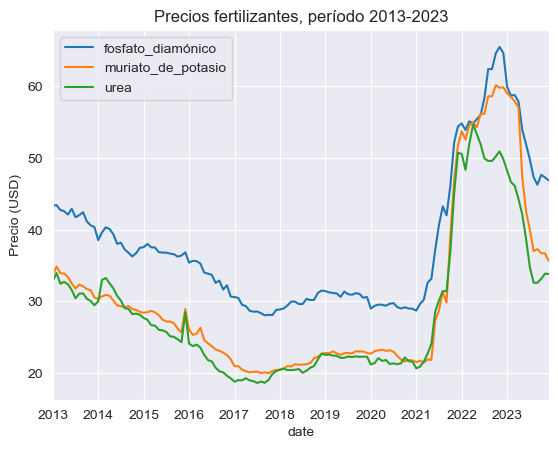

In [49]:
# Graficar precios de fertilizantes:
precios_fertilizantes.plot()
plt.title(f"Precios fertilizantes, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("Precio (USD)")
plt.show()

### Gas natural y crudo Brent Europa

In [50]:
# Importar datos de precios de gas natural en Europa:
precio_commodities_Europa = pd.read_excel(
    'data\precios_commodities.xlsx',
    usecols=['date', 'gas_natural_europa_usd_mmbtu', 'precio_crudo_brent_usd_barril']
    )

precio_commodities_Europa['date'] = precio_commodities_Europa['date']\
    .str.replace('M', '-')\

precio_commodities_Europa['date'] = pd.to_datetime(
    precio_commodities_Europa['date']
    ) + pd.offsets.MonthEnd(0)

precio_commodities_Europa = precio_commodities_Europa\
    .set_index('date')\
    [primer_año_análisis:último_año_análisis]
    

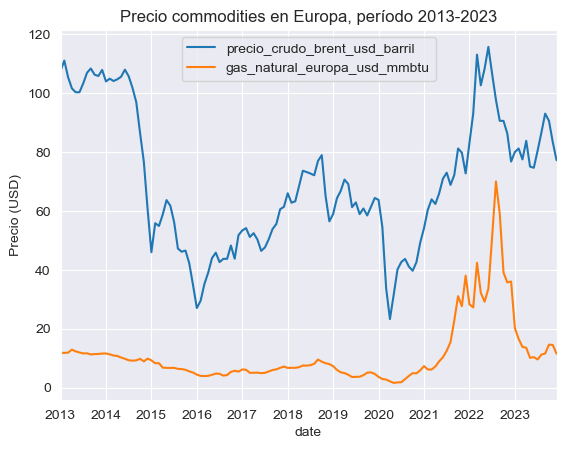

In [51]:
precio_commodities_Europa.plot()
plt.title(f"Precio commodities en Europa, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("Precio (USD)")
plt.show()

In [52]:
np.corrcoef(precios_fertilizantes['urea'], precio_commodities_Europa['gas_natural_europa_usd_mmbtu'])[0,1]

0.8383487066026571

### Inflación

In [53]:
inflación_mensual = pd.read_csv('data\inflación_mensual.csv')

inflación_mensual['Inflación mensual general'] = inflación_mensual['Inflación mensual general'].str.replace(',', '.')

inflación_mensual_nacional = inflación_mensual\
    .rename(columns={
        'Mes': 'date',
        'Inflación mensual general': 'inflación_mensual'
        })\
    .astype({
        'date': 'datetime64[ns]',
        'inflación_mensual': 'float'
        })\
    [inflación_mensual['Región'] == 'NACIONAL']\
    .drop(columns=['Año', 'Región'])\
    .set_index('date')\
    [primer_año_análisis:último_año_análisis]

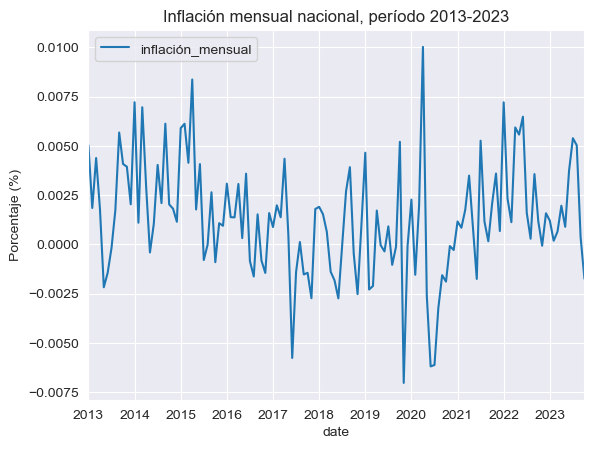

In [54]:
inflación_mensual_nacional.plot()
plt.title(f"Inflación mensual nacional, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("Porcentaje (%)")
plt.show()

### Precios combustibles

In [55]:
precios_combustibles = pd.read_excel('data\precios-combustibles.xlsx')

precios_combustibles['date'] = pd.to_datetime(precios_combustibles['date'])
precios_combustibles = precios_combustibles\
    .set_index('date')\
    [primer_año_análisis:último_año_análisis]


In [56]:
index_inferencias = pd.date_range(start='2013-01', end='2015-01', freq='M')

dict_precios_inferidos = {}

for col in precios_combustibles.columns:
    dict_precios_inferidos[col] = [precios_combustibles[col].iloc[0] for x in range(len(index_inferencias))]

precios_inferidos = pd.DataFrame(
    dict_precios_inferidos,
    index=index_inferencias
)

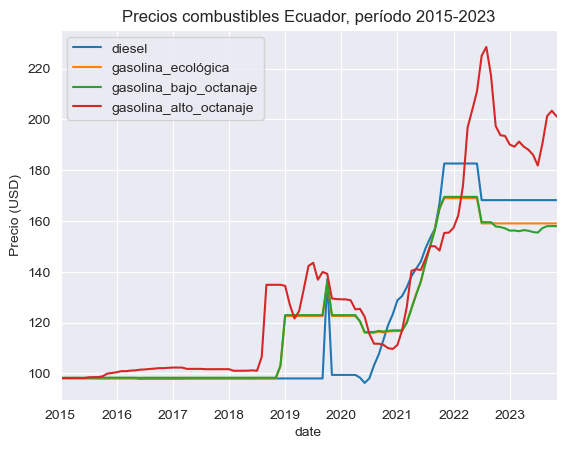

In [57]:
# Graficar precios de combustibles:
precios_combustibles.plot()
plt.title(f"Precios combustibles Ecuador, período 2015-{último_año_análisis}")
plt.ylabel("Precio (USD)")
plt.show()

### Precios WTI

In [58]:
precios_wti = pd.read_excel('data\precios_wti.xlsx')

# Convertir las columnas a formato largo (melt)
precios_wti = precios_wti.melt(
    id_vars=["Year"],
    var_name="Month",value_name="precio_wti"
    )

# Crear la columna 'Fecha' a partir de 'Year' y 'Month'
precios_wti['date'] = pd.to_datetime(precios_wti['Year'].astype(str) + '-' + precios_wti['Month'].str[0:3] + '-01')

# Seleccionar solo las columnas 'Fecha' y 'Price':
precios_wti = precios_wti[['date', 'precio_wti']]

# Ordenar por 'date' y establecer como índice; filtrar por período de análisis:
precios_wti = precios_wti\
    .sort_values('date')\
    .reset_index(drop=True)\
    .set_index('date')\
    [primer_año_análisis:último_año_análisis]

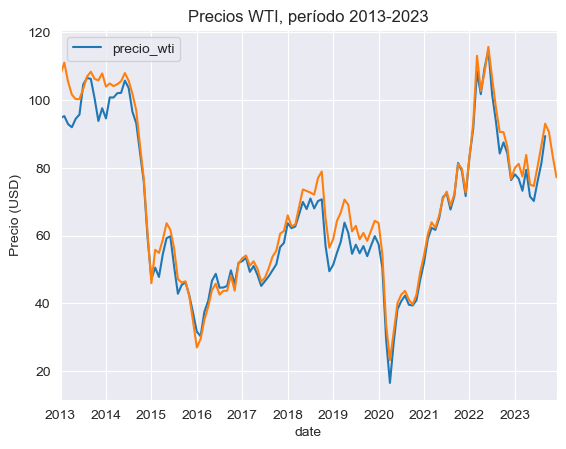

In [59]:
# Graficar:
precios_wti.plot()
precio_commodities_Europa['precio_crudo_brent_usd_barril'].plot()
plt.title(f"Precios WTI, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("Precio (USD)")

plt.show()

### Datos energía eléctrica

In [13]:
# Importar datos de consumo eléctrico en diccionario, {año:DataFrame}
rango_años = np.arange(2013, 2024, 1)

dict_df_electricidad = {
    str(año): pd.read_excel(
        f'data/energía-eléctrica/rpConsolidadoFacCliRegxParr-{año}.xlsx',
        usecols=['año', 'mes', 'grupo_consumo',	'provincia', 'cantón', 'energía_facturada_kwh', 'facturación_electricidad_usd'],
        engine='openpyxl'
        ) for año in rango_años
    }

In [110]:
# Concatenar DataFrames verticalmente:
datos_electricidad = pd.concat(dict_df_electricidad.values(), axis=0, ignore_index=True)

mapeo_meses = {'Ene': '01', 'Feb': '02', 'Mar': '03', 'Abr': '04', 'May': '05', 'Jun': '06', 
               'Jul': '07', 'Ago': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dic': '12'}

datos_electricidad['date'] = pd.to_datetime(
    datos_electricidad['año'].astype(str) + \
        '-' + \
        datos_electricidad['mes'].map(mapeo_meses)
        ) + pd.offsets.MonthEnd(0)

datos_electricidad = datos_electricidad\
    .reset_index()\
    .sort_values(by='date')\
    .set_index('date')\
    .drop(columns=['index', 'año', 'mes'])\
    ['2014':'2023']
    

In [111]:
# Creación de variable de costo de electricidad (USD) por cada kwh: 

# Reemplazar ceros de las variables de origen por su mediana:
for var in ('energía_facturada_kwh', 'facturación_electricidad_usd'):    
    datos_electricidad[var].replace(0, datos_electricidad[var].mean(), inplace=True)

# Cálculo de la variable:
datos_electricidad['valor_usd_kwh'] = datos_electricidad['facturación_electricidad_usd'] / datos_electricidad['energía_facturada_kwh']


<Axes: xlabel='date'>

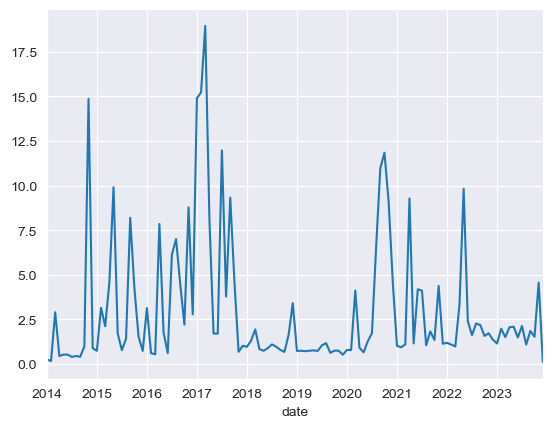

In [112]:
datos_electricidad.groupby(pd.Grouper(freq='M'))['valor_usd_kwh'].mean().plot()

In [113]:
datos_electricidad.groupby('grupo_consumo')['valor_usd_kwh'].mean()

grupo_consumo
Alumbrado Público    131.269578
Comercial              0.110993
Industrial             0.168777
Otros                  0.627826
Residencial            0.154735
Name: valor_usd_kwh, dtype: float64

In [114]:
# Filtramos el consumo eléctrico industrial:
datos_electricidad_industrial = datos_electricidad.query("grupo_consumo == 'Industrial'").copy()

In [115]:
# Calcula el Q1 y Q3
Q1 = datos_electricidad_industrial['valor_usd_kwh'].quantile(0.25)
Q3 = datos_electricidad_industrial['valor_usd_kwh'].quantile(0.75)

# Calcula el IQR
IQR = Q3 - Q1

# Define los límites para identificar valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar valores atípicos
outliers = datos_electricidad_industrial[
    (datos_electricidad_industrial['valor_usd_kwh'] < lower_bound) | 
    (datos_electricidad_industrial['valor_usd_kwh'] > upper_bound)
]

# Mostrar valores atípicos
outliers.sort_values(by='valor_usd_kwh', ascending=False)

,grupo_consumo,provincia,cantón,energía_facturada_kwh,facturación_electricidad_usd,valor_usd_kwh
date,,,,,,
2014-03-31,Industrial,AZUAY,CAMILO PONCE ENRÍQUEZ,7.0,32831.877718,4690.268245
2016-12-31,Industrial,EL ORO,PIÑAS,7.0,1194.990000,170.712857
2022-03-31,Industrial,BOLÍVAR,CHILLANES,2.0,229.780000,114.890000
2015-05-31,Industrial,PICHINCHA,MEJÍA,-4.0,-446.280000,111.570000
2023-07-31,Industrial,TUNGURAHUA,AMBATO,2.0,178.160000,89.080000
...,...,...,...,...,...,...
2017-04-30,Industrial,LOS RÍOS,PUEBLOVIEJO,31.0,-1025.260000,-33.072903
2020-05-31,Industrial,LOJA,SARAGURO,766.0,-56593.040000,-73.881253
2015-03-31,Industrial,AZUAY,CAMILO PONCE ENRÍQUEZ,-2.0,173.460000,-86.730000


In [116]:
# Reemplazar valores atípicos con la mediana
datos_electricidad_industrial['valor_usd_kwh'] = np.where(
    (datos_electricidad_industrial['valor_usd_kwh'] < lower_bound) | 
    (datos_electricidad_industrial['valor_usd_kwh'] > upper_bound),
    datos_electricidad_industrial['valor_usd_kwh'].median(),
    datos_electricidad_industrial['valor_usd_kwh']
)

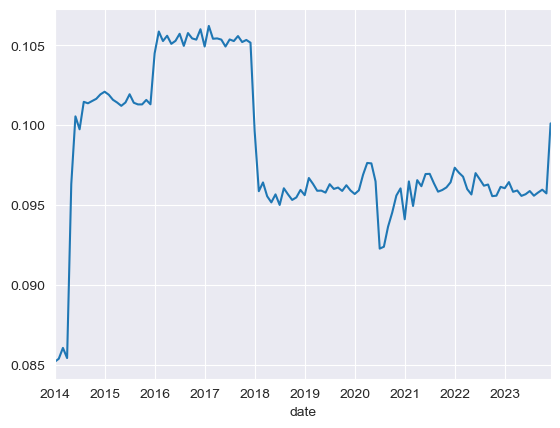

In [152]:
tarifa_eléctrica_industrial_media_mensual = datos_electricidad_industrial\
    .groupby(pd.Grouper(freq='M'))\
    ['valor_usd_kwh']\
    .mean()

tarifa_eléctrica_industrial_media_mensual.plot(kind='line')
plt.show()

In [118]:
tarifa_eléctrica_industrial_media_mensual['2023']

date
2023-01-31    0.096043
2023-02-28    0.096426
2023-03-31    0.095818
2023-04-30    0.095899
2023-05-31    0.095562
2023-06-30    0.095666
2023-07-31    0.095865
2023-08-31    0.095573
2023-09-30    0.095772
2023-10-31    0.095950
2023-11-30    0.095718
2023-12-31    0.100099
Freq: M, Name: valor_usd_kwh, dtype: float64

### Datos climáticos

In [119]:
# URL del archivo JSON
url = "https://cckpapi.worldbank.org/cckp/v1/cru-x0.5_timeseries_pr,tas_timeseries_monthly_1901-2022_mean_historical_cru_ts4.07_mean/ECU?_format=json"

# Leer el archivo JSON desde la URL y cargarlo en un DataFrame de pandas
datos_climáticos_bm = pd.read_json(url)\
    .drop(columns=['metadata'])\
    .dropna()


# Inicializa el diccionario de salida:
dict_datos_climáticos = {}

# Itera sobre el índice del DataFrame:
for i in datos_climáticos_bm.index:
    # Extrae los valores directamente y aplana la lista anidada
    flattened_values = [v for sublist in datos_climáticos_bm.loc[i].values[0].values() for v in sublist.values()]
    # Asigna los valores al diccionario:
    dict_datos_climáticos[i] = flattened_values

# Crear una serie de fechas entre fecha_inicial y fecha_final:
serie_fechas = pd.date_range(start='1901-01', end='2023-01', freq='M')

datos_climáticos = pd.DataFrame(
    dict_datos_climáticos,
    index=serie_fechas
    )\
    .rename(columns={'pr': 'precipitación_media_mm', 'tas':'temp_media_Celsius'})\
    [primer_año_análisis:último_año_análisis]

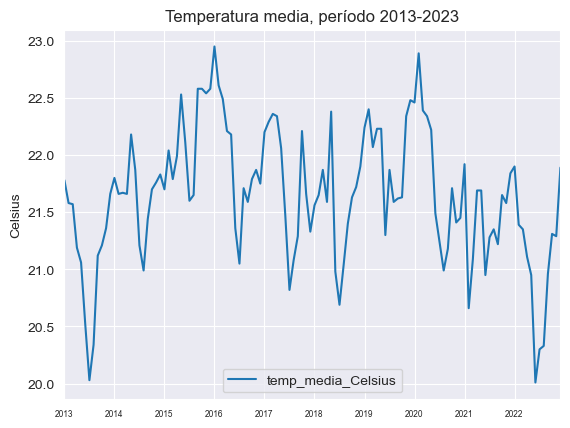

In [120]:
# Graficar temperatura media:
datos_climáticos['temp_media_Celsius'].plot()
plt.title(f"Temperatura media, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("Celsius")
plt.legend()

plt.show()

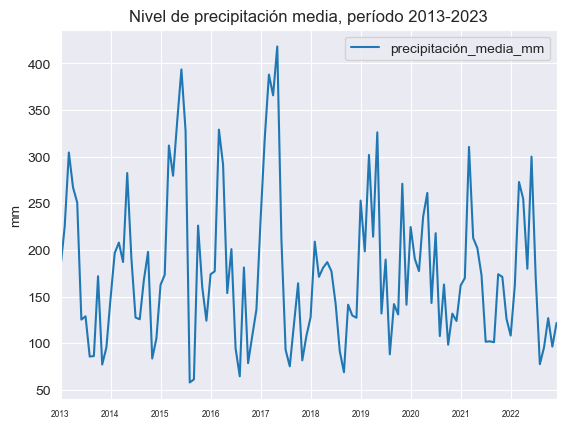

In [121]:
# Graficar precipitaciones:
datos_climáticos['precipitación_media_mm'].plot()
plt.title(f"Nivel de precipitación media, período {primer_año_análisis}-{último_año_análisis}")
plt.ylabel("mm")
plt.legend()

plt.show()
plt.show()

In [122]:
# Datos de temperatura y precipitaciones SIPA:
datos_climáticos_sipa = pd.read_excel(r'data\temperatura-precipitacion-sipa.xlsx', sheet_name='temperatura_precipitación')

datos_climáticos_sipa.head(5)

,Año,Mes,Estación,Provincia,Cantón,Precipitación (mm),Temperatura promedio (°C)
0,2000,Enero,Inguincho,Imbabura,Otavalo,115.2,9.2
1,2000,Febrero,Inguincho,Imbabura,Otavalo,113.3,9.2
2,2000,Marzo,Inguincho,Imbabura,Otavalo,121.7,9.8
3,2000,Abril,Inguincho,Imbabura,Otavalo,290.7,10.1
4,2000,Mayo,Inguincho,Imbabura,Otavalo,253.5,10.0


In [123]:
# Agregar datos para obtener valores medios nacionales:
datos_climáticos_sipa = datos_climáticos_sipa\
    .rename(columns={'Precipitación (mm)': 'precipitación_media_mm', 'Temperatura promedio (°C)':'temp_media_Celsius'})\
    .groupby(['Año', 'Mes'])\
    [['precipitación_media_mm', 'temp_media_Celsius']]\
    .mean()\
    .reset_index()

In [124]:
# Diccionario para mapear meses por sus equivalentes numéricos:
meses = {
    'Enero': '01',
    'Febrero': '02',
    'Marzo': '03',
    'Abril': '04',
    'Mayo': '05',
    'Junio': '06',
    'Julio': '07',
    'Agosto': '08',
    'Septiembre': '09',
    'Octubre': '10',
    'Noviembre': '11',
    'Diciembre': '12'
}

# Crear la columna de fecha combinando 'Año' y 'Mes':
datos_climáticos_sipa['date'] = pd.to_datetime(
    datos_climáticos_sipa['Año'].astype(str) + \
    '-' + \
    datos_climáticos_sipa['Mes'].map(meses)
    ) + pd.offsets.MonthEnd(0)  # Ajusta al último día del mes

datos_climáticos_sipa = datos_climáticos_sipa\
    .sort_values(by='date')\
    .set_index('date')\
    .drop(columns=['Año', 'Mes'])\
    [primer_año_análisis:'2022']

Correlación precipitación_media_mm:  0.697450024430516
Correlación temp_media_Celsius:  0.5489464438969055


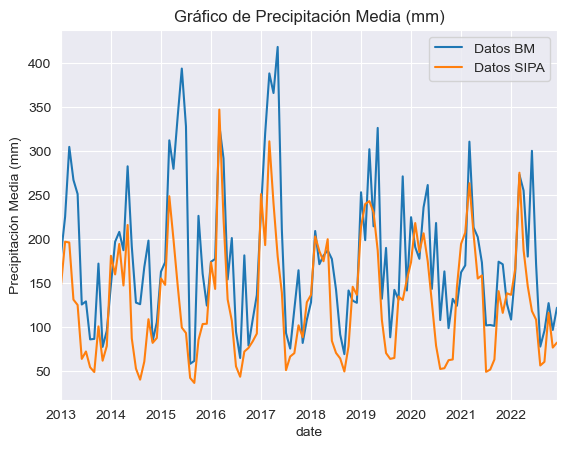

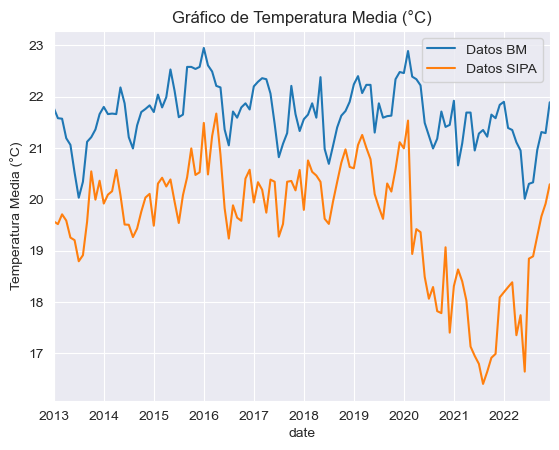

In [125]:
# Revisamos correlaciones entre fuentes de datos distintas:
for col in ('precipitación_media_mm', 'temp_media_Celsius'):
    print(f"Correlación {col}: ", datos_climáticos[col].corr(datos_climáticos_sipa[col][:'2022']))

# Gráfica para precipitación_media_mm
datos_climáticos['precipitación_media_mm'].plot(label='Datos BM')
datos_climáticos_sipa['precipitación_media_mm'].plot(label='Datos SIPA')
plt.legend()
plt.title('Gráfico de Precipitación Media (mm)')
plt.xlabel('date')
plt.ylabel('Precipitación Media (mm)')
plt.show()

# Gráfica para temp_media_Celsius
datos_climáticos['temp_media_Celsius'].plot(label='Datos BM')
datos_climáticos_sipa['temp_media_Celsius'].plot(label='Datos SIPA')
plt.legend()
plt.title('Gráfico de Temperatura Media (°C)')
plt.xlabel('date')
plt.ylabel('Temperatura Media (°C)')
plt.show()


### Importaciones de Insumos Agrícolas

In [126]:
insumos_agrícolas = pd.read_excel('data\importaciones_cif_por_uso.xlsx', sheet_name='insumos_agrícolas')

In [127]:
insumos_agrícolas['date'] = pd.to_datetime(
    insumos_agrícolas['Año'].astype(str) +\
    '-' + \
    insumos_agrícolas['Num Mes'].astype(str)
    ) + pd.offsets.MonthEnd(0)

insumos_agrícolas['Código Matricero'] = insumos_agrícolas['Código Matricero'].astype(str)

insumos_agrícolas = insumos_agrícolas\
    .set_index('date')\
    .drop(columns=['Año', 'Num Mes'])\
    .rename(columns={
        'Valor CIF dólar en miles': 'cif_miles_usd',
        'Matricero': 'matricero_insumos_agrícolas'})\
    [primer_año_análisis:último_año_análisis]
    

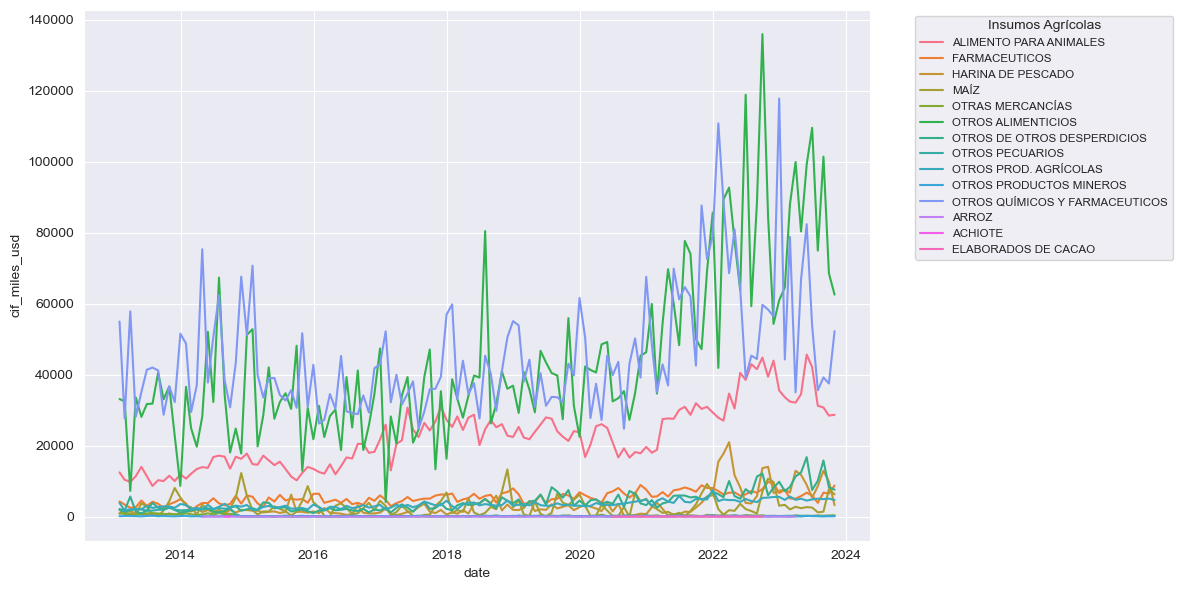

In [147]:
# Crear el gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='cif_miles_usd', data=insumos_agrícolas.reset_index(), hue='matricero_insumos_agrícolas')
plt.legend(title='Insumos Agrícolas', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [129]:
# Crear el DataFrame de insumos como variables, con tabla pivote:
X_insumos = insumos_agrícolas.pivot_table(
    values='cif_miles_usd', 
    index='date', 
    columns='matricero_insumos_agrícolas', 
    aggfunc='sum',
    fill_value=0
    )

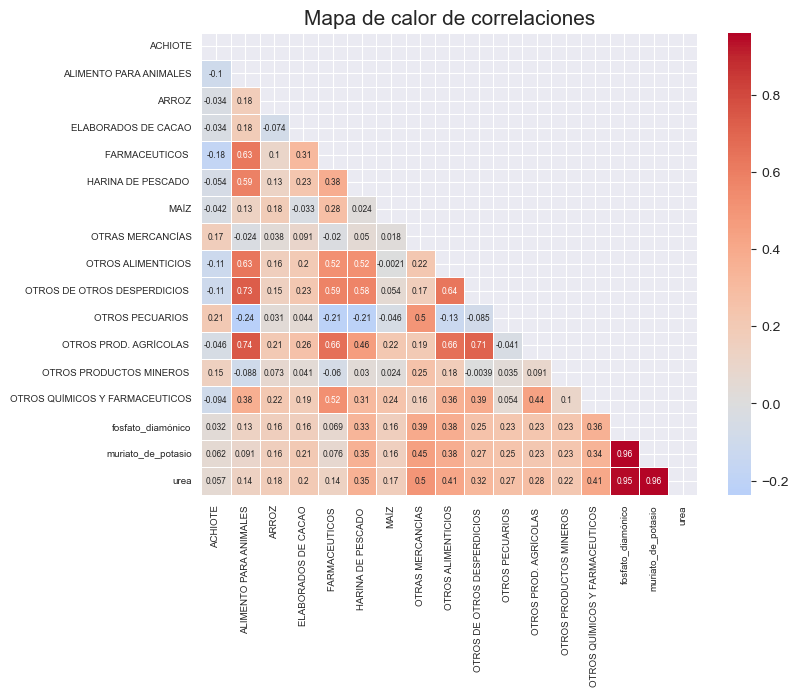

In [149]:
# Unir los DataFrames de insumos y fertilizantes por índice (fechas):
insumos_agrícolas_y_fertilizantes = X_insumos.merge(precios_fertilizantes, left_index=True, right_index=True, how='left')

# Graficar mapa de calor de correlaciones no lineales:
corr = insumos_agrícolas_y_fertilizantes.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=True, annot_kws={"size": 6})
plt.title('Mapa de calor de correlaciones', size=15)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()


In [131]:
import statsmodels.api as sm

# Obtener las variables características regularizadas con una constante:
const_X = sm.add_constant(X_insumos)

target_var = 'urea'

y = insumos_agrícolas_y_fertilizantes[target_var].to_frame()

# Ajustamos una regresión OLS robusta con HC1 para posibles valores atípicos:
model = sm.OLS(y, const_X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   urea   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     17.70
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           1.56e-22
Time:                        14:42:54   Log-Likelihood:                -393.64
No. Observations:                 130   AIC:                             817.3
Df Residuals:                     115   BIC:                             860.3
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [132]:
from sklearn.preprocessing import RobustScaler

# Escalar datos:
X_scaler = RobustScaler()
X_insumos_escalado = X_scaler.fit_transform(X_insumos)

y_scaler = RobustScaler()
y_escalado = y_scaler.fit_transform(y)

# Definir el tamaño del conjunto de entrenamiento
train_size = int(len(X_insumos_escalado) * 0.8)

# Dividir los datos
X_train, X_test = X_insumos_escalado[:train_size], X_insumos_escalado[train_size:]
y_train, y_test = y_escalado[:train_size], y_escalado[train_size:]

In [133]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

# Definimos una lista de alphas para probar
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Creamos el modelo LassoCV
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=5000)

# Ajustamos el modelo LassoCV a los datos escalados
lasso_cv.fit(X_train, y_train.ravel())

# Obtenemos el alpha óptimo para Lasso
optimal_alpha_lasso = lasso_cv.alpha_
print("Alpha óptimo para Lasso:", optimal_alpha_lasso)

# Ajustar el modelo Lasso con el alpha óptimo
lasso_opt = Lasso(alpha=optimal_alpha_lasso)
lasso_opt.fit(X_insumos_escalado, y_escalado)

# Predecimos con el modelo Lasso:
lasso_predictions = lasso_opt.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print("MSE Lasso: ", lasso_mse)


Alpha óptimo para Lasso: 0.001
MSE Lasso:  0.49979840338784354


In [134]:
from sklearn.linear_model import Ridge, RidgeCV

# Creamos el modelo RidgeCV
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# Ajustamos el modelo RidgeCV a los datos escalados
ridge_cv.fit(X_train, y_train)

# Obtenemos el alpha óptimo para Ridge
optimal_alpha_ridge = ridge_cv.alpha_
print("Alpha óptimo para Ridge:", optimal_alpha_ridge)

# Ajustamos el modelo Ridge con el alpha óptimo
ridge_opt = Ridge(alpha=optimal_alpha_ridge)
ridge_opt.fit(X_insumos_escalado, y_escalado)

# Predecimos con el modelo Ridge:
ridge_predictions = ridge_opt.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
print("MSE Ridge: ", ridge_mse)

Alpha óptimo para Ridge: 10.0
MSE Ridge:  0.5303765688786684


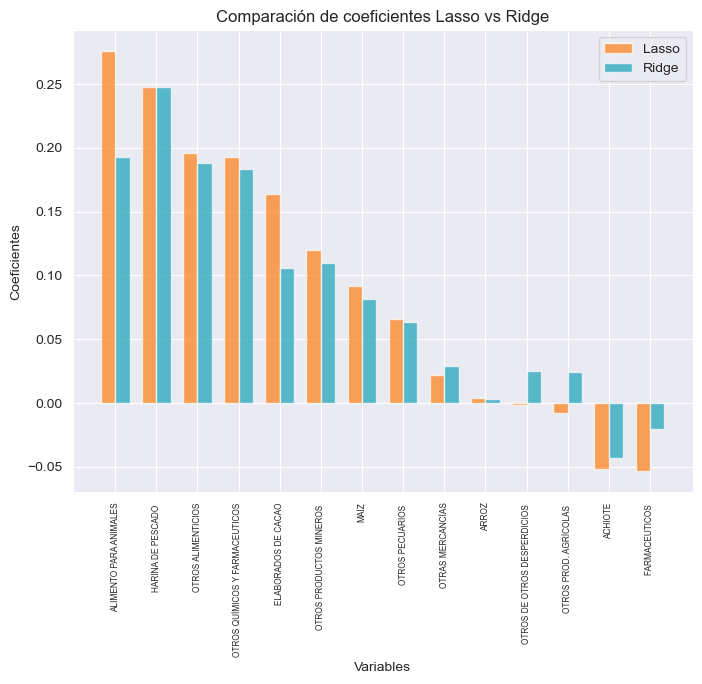

In [135]:
# Creamos un DataFrame con los coeficientes Lasso y Ridge:
regularization_coefs = pd.DataFrame(
    {'X': X_insumos.columns, 
    'lasso_coefs': lasso_opt.coef_.flatten(),
    'ridge_coefs': ridge_opt.coef_.flatten()}
    )

# Ordenamos el DataFrame según los coeficientes de Lasso (o Ridge) en orden descendente:
regularization_coefs = regularization_coefs.sort_values(by=['lasso_coefs', 'ridge_coefs'], ascending=[False, False])

# Creamos un gráfico de barras comparativo:
bar_width = 0.35
index = np.arange(len(regularization_coefs['X']))

fig, ax = plt.subplots(figsize=(8, 6))
bar1 = ax.bar(index, regularization_coefs['lasso_coefs'], bar_width, label='Lasso', color='#fd7e14', alpha=0.7)
bar2 = ax.bar(index + bar_width, regularization_coefs['ridge_coefs'], bar_width, label='Ridge', color='#17a2b8', alpha=0.7)

ax.set_xlabel('Variables')
ax.set_ylabel('Coeficientes')
ax.set_title('Comparación de coeficientes Lasso vs Ridge')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(regularization_coefs['X'], rotation=90, fontsize=6)
ax.legend()
plt.show()

### Exportaciones

In [136]:
exportaciones = pd.read_excel(
    r'data\exportaciones_fob.xlsx',
    sheet_name='Mensual',
    usecols=['Año', 'Num Mes', 'Matricero', 'Valor FOB Dólar en miles']
    )

In [137]:
exportaciones['date'] = pd.to_datetime(
    exportaciones['Año'].astype(str) +\
    '-' + \
    exportaciones['Num Mes'].astype(str)
    ) + pd.offsets.MonthEnd(0)

exportaciones = exportaciones\
    .set_index('date')\
    .drop(columns=['Año', 'Num Mes'])\
    .rename(columns={
        'Valor FOB Dólar en miles': 'fob_miles_usd',
        'Matricero': 'matricero_exportaciones'})\
    [primer_año_análisis:último_año_análisis]

In [138]:
lista_exportaciones_relevantes = sorted(
    ['PRODUCTOS AGRICOLAS EN CONSERVA ', 'OTRAS FIBRAS VEGETALES', 'CARNE, LECHE Y ELABORADOS ', 'PIÑAS ',
    'HOJAS DE TÉ ', 'MELONES ', 'OTROS PROD. AGRÍCOLAS ', 'OTRAS FRUTAS', 'TABACO EN RAMA',
    'OTROS ALIMENTICIOS', 'JUGOS Y CONSERVAS DE FRUTAS ', 'EXTRACTOS Y ACEITES VEGETALES ',
    'ABACÁ ', 'HARINA Y ELABORADOS DE CEREALES ', 'OTROS QUÍMICOS Y FARMACEUTICOS', 'FLORES NATURALES',
    'CAFÉ INDUSTRIALIZADO', 'HARINA DE PESCADO ', 'CAFÉ LAVADO ', 'ELABORADOS DE CACAO ', 'CACAO ',
    'PLÁTANO ', 'ELABORADOS DE BANANO',  'ALIMENTO PARA ANIMALES', 'ALGODÓN ', 'AZÚCAR', 'MAÍZ', 'ARROZ ',
    'MELAZAS Y PANELAS ', 'NARANJAS', 'BANANO', 'CONÍFERAS ', 'ACHIOTE ', 'CAFE NATURAL']
    )

exportaciones_relevantes = exportaciones[exportaciones['matricero_exportaciones'].isin(lista_exportaciones_relevantes)]

In [139]:
# Crear el DataFrame de insumos como variables, con tabla pivote:
X_exportaciones = exportaciones_relevantes.pivot_table(
    values='fob_miles_usd', 
    index='date', 
    columns='matricero_exportaciones', 
    aggfunc='sum',
    fill_value=0
    )

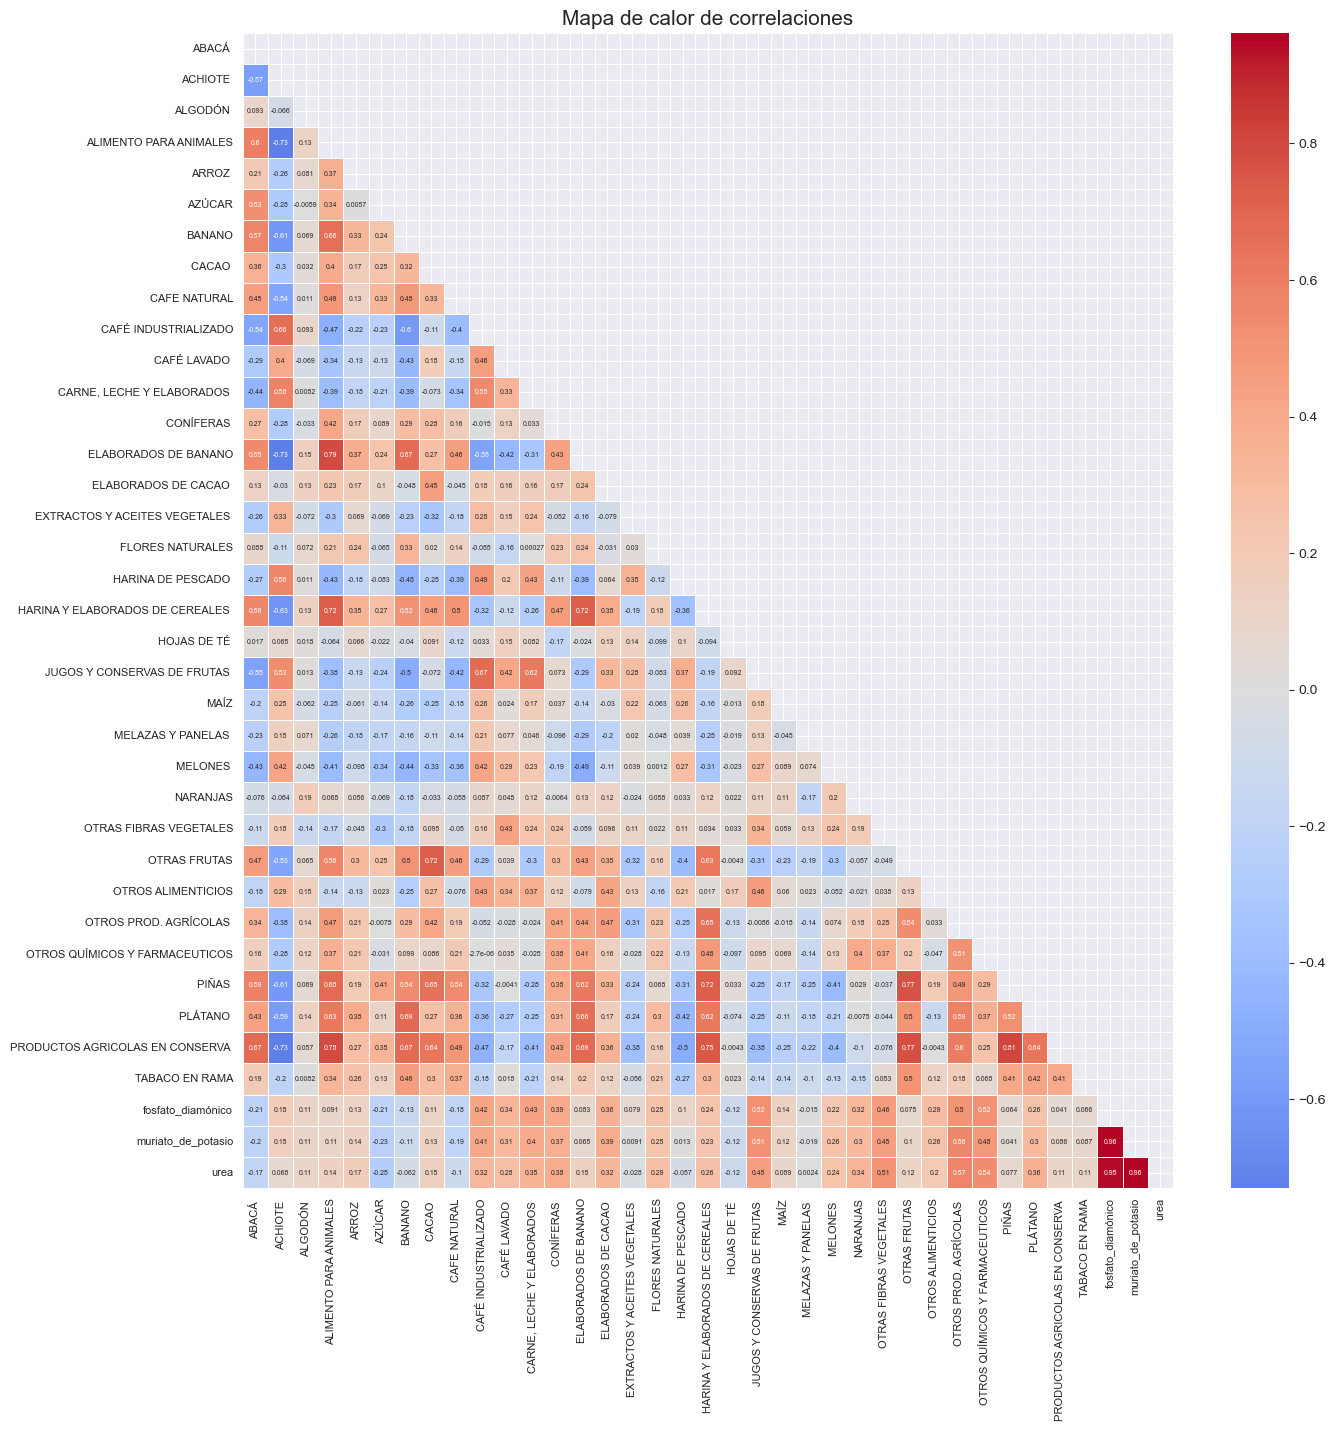

In [140]:
# Unir los DataFrames de insumos y fertilizantes por índice (fechas):
exportaciones_y_fertilizantes = X_exportaciones.merge(precios_fertilizantes, left_index=True, right_index=True, how='left')

# Graficar mapa de calor de correlaciones no lineales:
corr = exportaciones_y_fertilizantes.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(15, 15))
sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=True, annot_kws={"size": 5})
plt.title('Mapa de calor de correlaciones', size=15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [141]:
from sklearn.preprocessing import RobustScaler

# Escalar datos:
X_scaler = RobustScaler()
X_exportaciones_escalado = X_scaler.fit_transform(X_exportaciones)

y_scaler = RobustScaler()
y_escalado = y_scaler.fit_transform(y)

# Definir el tamaño del conjunto de entrenamiento
train_size = int(len(X_exportaciones_escalado) * 0.8)

# Dividir los datos
X_train, X_test = X_exportaciones_escalado[:train_size], X_exportaciones_escalado[train_size:]
y_train, y_test = y_escalado[:train_size], y_escalado[train_size:]

In [142]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

# Definimos una lista de alphas para probar
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Creamos el modelo LassoCV
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=5000)

# Ajustamos el modelo LassoCV a los datos escalados
lasso_cv.fit(X_train, y_train.ravel())

# Obtenemos el alpha óptimo para Lasso
optimal_alpha_lasso = lasso_cv.alpha_
print("Alpha óptimo para Lasso:", optimal_alpha_lasso)

# Ajustar el modelo Lasso con el alpha óptimo
lasso_opt = Lasso(alpha=optimal_alpha_lasso)
lasso_opt.fit(X_exportaciones_escalado, y_escalado)

# Predecimos con el modelo Lasso:
lasso_predictions = lasso_opt.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print("MSE Lasso: ", lasso_mse)

Alpha óptimo para Lasso: 0.01
MSE Lasso:  0.2650670718175769


In [143]:
from sklearn.linear_model import Ridge, RidgeCV

# Creamos el modelo RidgeCV
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# Ajustamos el modelo RidgeCV a los datos escalados
ridge_cv.fit(X_train, y_train)

# Obtenemos el alpha óptimo para Ridge
optimal_alpha_ridge = ridge_cv.alpha_
print("Alpha óptimo para Ridge:", optimal_alpha_ridge)

# Ajustamos el modelo Ridge con el alpha óptimo
ridge_opt = Ridge(alpha=optimal_alpha_ridge)
ridge_opt.fit(X_exportaciones_escalado, y_escalado)

# Predecimos con el modelo Ridge:
ridge_predictions = ridge_opt.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
print("MSE Ridge: ", ridge_mse)

Alpha óptimo para Ridge: 1.0
MSE Ridge:  0.23311052900405543


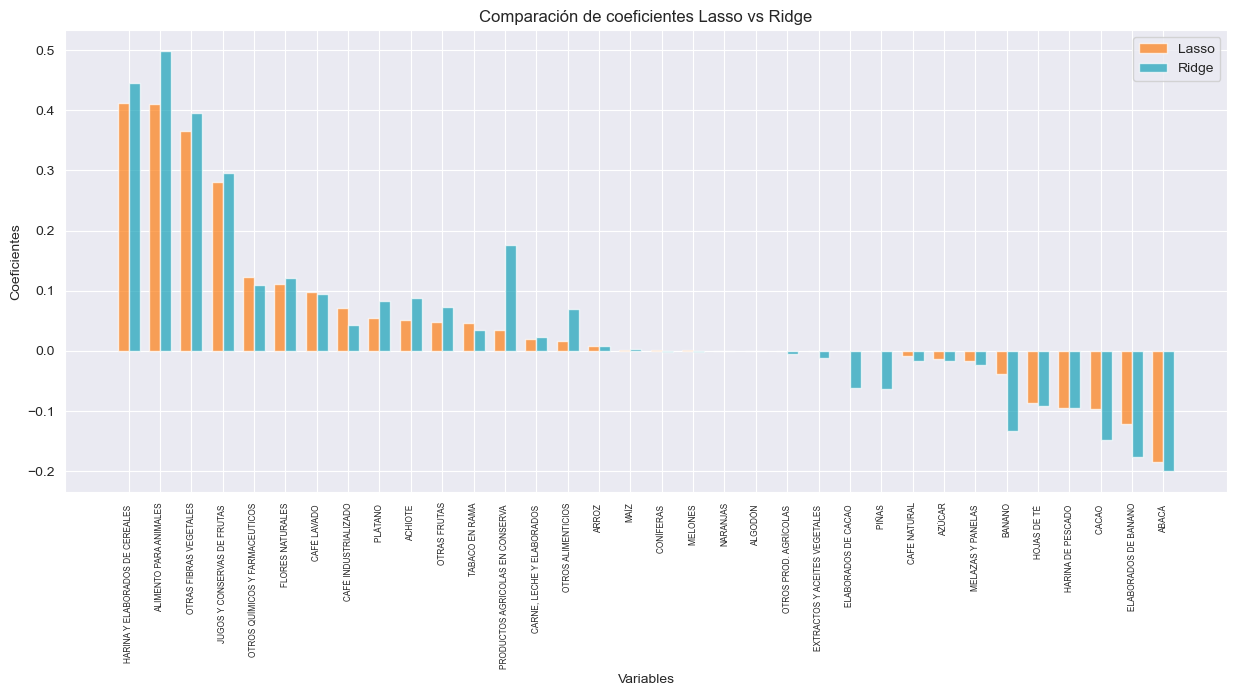

In [144]:
# Creamos un DataFrame con los coeficientes Lasso y Ridge:
regularization_coefs = pd.DataFrame(
    {'X': X_exportaciones.columns, 
    'lasso_coefs': lasso_opt.coef_.flatten(),
    'ridge_coefs': ridge_opt.coef_.flatten()}
    )

# Ordenamos el DataFrame según los coeficientes de Lasso (o Ridge) en orden descendente:
regularization_coefs = regularization_coefs.sort_values(by=['lasso_coefs', 'ridge_coefs'], ascending=[False, False])

# Creamos un gráfico de barras comparativo:
bar_width = 0.35
index = np.arange(len(regularization_coefs['X']))

fig, ax = plt.subplots(figsize=(15, 6))
bar1 = ax.bar(index, regularization_coefs['lasso_coefs'], bar_width, label='Lasso', color='#fd7e14', alpha=0.7)
bar2 = ax.bar(index + bar_width, regularization_coefs['ridge_coefs'], bar_width, label='Ridge', color='#17a2b8', alpha=0.7)

ax.set_xlabel('Variables')
ax.set_ylabel('Coeficientes')
ax.set_title('Comparación de coeficientes Lasso vs Ridge')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(regularization_coefs['X'], rotation=90, fontsize=6)
ax.legend()
plt.show()

### Subsidio urea

Fuente: https://www.agricultura.gob.ec/agricultores-pagaran-el-50-del-costo-comercial-del-saco-de-urea/

In [145]:
index_subsidio = pd.date_range(start='2013-01', end='2024-01', freq='M')

subsidio_urea = pd.DataFrame(index=index_subsidio, columns=['tiene_subsidio_urea'])
subsidio_urea['tiene_subsidio_urea'] = False

# Meses en los que hay subsidio de urea:
meses_con_subsidio = pd.date_range(start='2022-07', end='2024-01', freq='M')

# Marca como True los meses en los que hay subsidio de urea
subsidio_urea.loc[meses_con_subsidio, 'tiene_subsidio_urea'] = True